In [1]:
import pandas as pd
import numpy as np
import uuid
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
sns.set_style("ticks")

Olist conducted an experiment to see if altering the delivery estimation could result in higher review scores.

# Generate random data for A/B testing

In [2]:
date_range = pd.date_range(start="2018-07-01", end="2018-09-01")

In [3]:
date_range

DatetimeIndex(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04',
               '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08',
               '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12',
               '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16',
               '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20',
               '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24',
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05',
               '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09',
               '2018-08-10', '2018-08-11', '2018-08-12', '2018-08-13',
               '2018-08-14', '2018-08-15', '2018-08-16', '2018-08-17',
               '2018-08-18', '2018-08-19', '2018-08-20', '2018-08-21',
               '2018-08-22', '2018-08-23', '2018-08-24', '2018-08-25',
      

In [4]:
np.datetime64("2018-07-15")

numpy.datetime64('2018-07-15')

In [5]:
control = {1: 10,
           2: 3,
           3: 8,
           4: 20,
           5: 59}

test = {1: 10,
        2: 2,
        3: 10,
        4: 22,
        5: 63}

def generate_review_distribution(freq_dict):
    l = []
    for key, value in freq_dict.items():
        l += [key] * value
    return l

In [6]:
def get_random_review(date, group):
    if (group == 102) & (date >= np.datetime64("2018-07-15")):
        random_reviews = generate_review_distribution(test)
    else:
        random_reviews = generate_review_distribution(control)
    return random.choice(random_reviews)
    
def generate_random_observation(date, group):
    return str(uuid.uuid4()), get_random_review(date, group)

In [7]:
# create list of dicts to later on convert to a dataframe
rows = []
for date in date_range:
    # two groups
    for group in [101,102]:
        # pick a random number of orders btw 350 and 450
        orders = random.choice(range(350,450))
        for obs in range(orders):
            order_id, review_score = generate_random_observation(date, group)
            rows.append({"date_id": date,
                         "experiment_id": group,
                         "order_id": order_id,
                         "review_score": review_score})
            
df = pd.DataFrame(rows)

In [8]:
df

,date_id,experiment_id,order_id,review_score
0,2018-07-01,101,3a8508ea-2d56-4d39-98b9-857531ae3b44,5
1,2018-07-01,101,7c1d06e3-430f-494c-bceb-a17d9436eb6a,4
2,2018-07-01,101,826cd4d7-aa1d-41f2-9f58-559cd4fb380d,1
3,2018-07-01,101,99b03509-d442-4cb7-a3b8-c2414ecc5727,3
4,2018-07-01,101,9f49e63a-2b82-4b4e-a0a3-84c9ce4401f3,4
...,...,...,...,...
50347,2018-09-01,102,646ac244-5cb2-4853-9252-f5574731b9b6,5
50348,2018-09-01,102,bd745507-49e0-4df8-8887-05b5718db9ef,5
50349,2018-09-01,102,983ae80c-effb-4ac4-9c8c-444a04e16a4d,5
50350,2018-09-01,102,2793de62-c871-442e-9fd9-028fd302abf4,2


### Plot data and calculate means

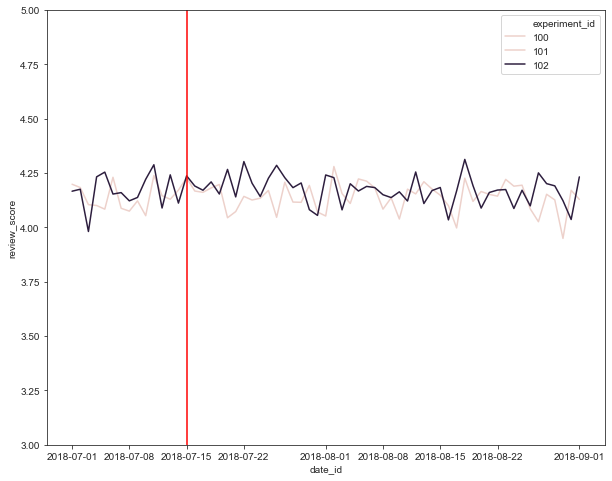

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df.groupby(["date_id", "experiment_id"]).mean().reset_index(),
             x="date_id",
             y="review_score",
             hue="experiment_id",
             ax=ax);
ax.axvline("2018-07-15", color="r")
ax.set_ylim(3,5);

In [10]:
df[df["date_id"] > "2018-07-15"].groupby("experiment_id").mean()

,review_score
experiment_id,
101,4.138320
102,4.173084


In [11]:
df.to_csv("olist_experiment_data.csv")

How do we know if this difference did not just occure by chance?
We have uncertainty because we are looking at a sample and want to generalize to all users.


We use statistics => t-test

# Central Limit Theorem

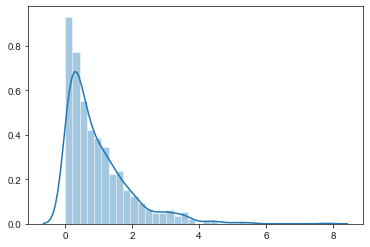

In [12]:
sns.distplot(np.random.exponential(size=1000));

In [13]:
means = []
for i in range(1000):
    means.append(np.random.exponential(size=1000).mean())

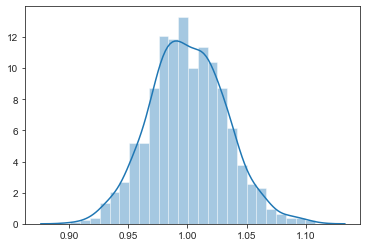

In [14]:
sns.distplot(means);

Create a function that allows us to tweak the parameters and use different distributions

In [15]:
def plot_clt(sample_size, repetition, distr):
    sample_means = [distr(size=sample_size).mean() for i in range(repetition)]
    sns.distplot(sample_means, color="r")

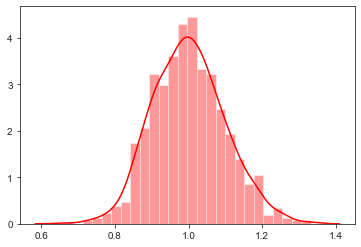

In [16]:
plot_clt(100, 1000, np.random.exponential)

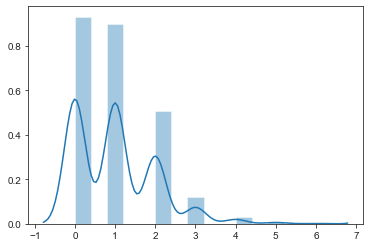

In [17]:
sns.distplot(np.random.poisson(size=1000));

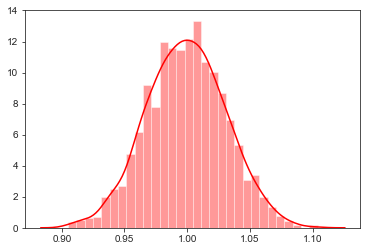

In [18]:
plot_clt(1000, 2000, np.random.poisson)

In [19]:
# alter function so I can layer multiple plots on the same graph
def plot_clt(sample_size, repetition, distr, ax=None, color=None):
    sample_means = [distr(size=sample_size).mean() for i in range(repetition)]
    sns.distplot(sample_means, color=color, ax=ax)

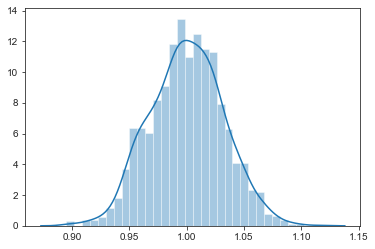

In [20]:
plot_clt(1000, 2000, np.random.poisson)

test the functions

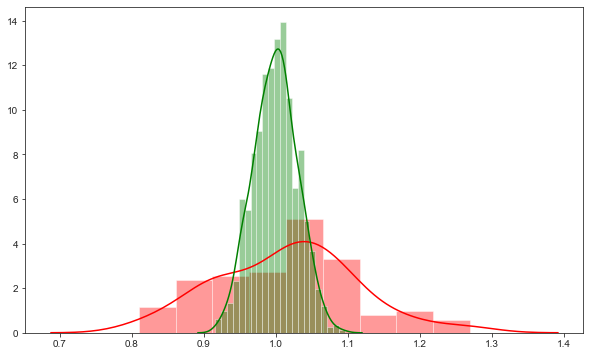

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
plot_clt(100,100,np.random.poisson,ax,"r")
plot_clt(1000,1000,np.random.poisson,ax,"g")

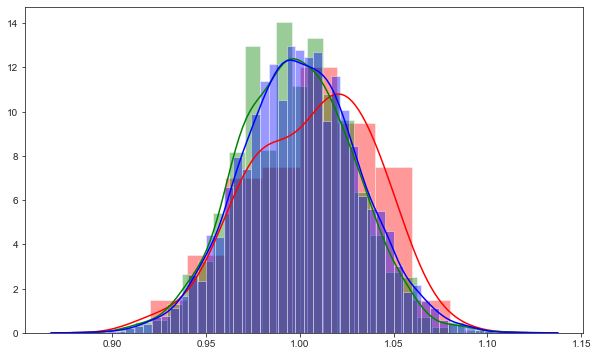

In [22]:
# alter repetitions, keep sample_size
fig, ax = plt.subplots(figsize=(10,6))
plot_clt(1000,100,np.random.poisson,ax,"r")
plot_clt(1000,1000,np.random.poisson,ax,"g")
plot_clt(1000,10000,np.random.poisson,ax,"b")

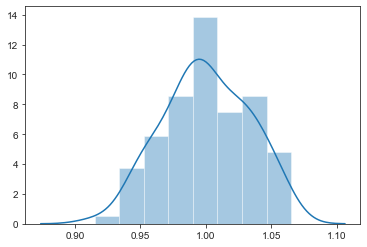

In [23]:
plot_clt(1000,100,np.random.poisson)

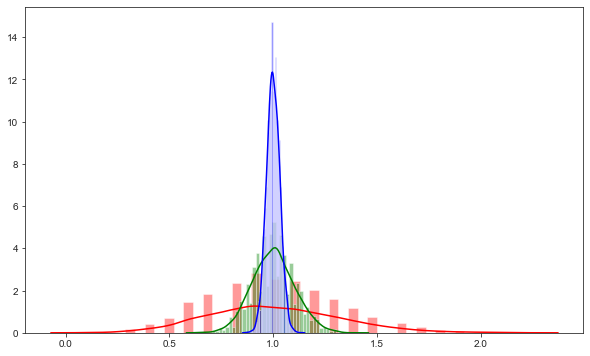

In [24]:
# keep repetitions, alter sample_size
fig, ax = plt.subplots(figsize=(10,6))
plot_clt(10,5000,np.random.poisson,ax,"r")
plot_clt(100,5000,np.random.poisson,ax,"g")
plot_clt(1000,5000,np.random.poisson,ax,"b")

# Run that t-test

Testing the hypothesis that our newly introduced change had no effect. 

Nullhypothesis:

$H_0: avg\_rating_{control} = avg\_rating_{test}$

$ <=> avg\_rating_{control} - avg\_rating_{test} = 0$

Against the alternative hypothesis:

$H_1: avg\_rating_{control} \neq avg\_rating_{test}$

In [25]:
df.dtypes

date_id          datetime64[ns]
experiment_id             int64
order_id                 object
review_score              int64
dtype: object

In [26]:
# we only started the experiment on 2018-07-15
df = df[df["date_id"].gt("2018-07-14")]
df.head()

,date_id,experiment_id,order_id,review_score
11248,2018-07-15,101,1ea1f3ec-935a-4cd5-8673-dfaa423e4036,3
11249,2018-07-15,101,bb40f0b8-ecad-461d-8a72-695068d42570,5
11250,2018-07-15,101,a2088312-a07a-4a6a-86ad-f3eb6fc458ae,1
11251,2018-07-15,101,717d3610-0188-415c-a29d-33e6890e89aa,5
11252,2018-07-15,101,5d5cd4fb-4a0a-4176-bf88-61269b4f7407,5


In [27]:
# get the means
means = (df
         .groupby("experiment_id")
         .agg({"review_score": "mean"})
         .rename(columns={"review_score": "avg_review_score"}))
means

,avg_review_score
experiment_id,
101,4.140234
102,4.174266


In [28]:
var = (df
       .groupby("experiment_id")
       .agg({"review_score": "var"})
       .rename(columns={"review_score": "review_score_var"}))
var

,review_score_var
experiment_id,
101,1.685181
102,1.582676


In [29]:
stds = (df
        .groupby("experiment_id")
        .agg({"review_score": "std"})
        .rename(columns={"review_score": "review_score_std"}))
stds

,review_score_std
experiment_id,
101,1.298145
102,1.258045


In [30]:
ssizes = (df
          .groupby("experiment_id")
          .agg({"review_score": "count"})
          .rename(columns={"review_score": "sample_size"}))
ssizes

,sample_size
experiment_id,
101,19496
102,19608


Plot the distribution of the sample mean

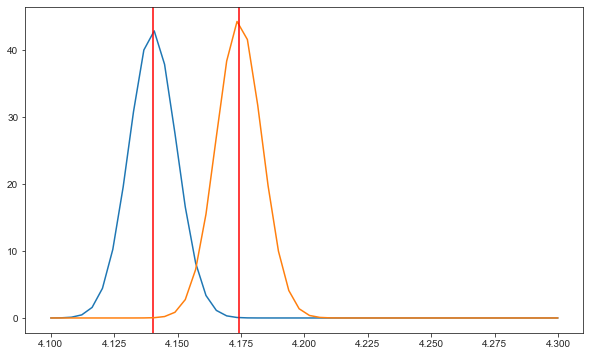

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
# control
# calculate the standard error
se_c = stds.loc[101,"review_score_std"] / np.sqrt(ssizes.loc[101,"sample_size"])
pdf_c = scipy.stats.norm.pdf(np.linspace(4.1,4.3),
                             means.loc[101,"avg_review_score"],
                             se_c)
plt.plot(np.linspace(4.1,4.3), pdf_c);
ax.axvline(means.loc[101,"avg_review_score"], color="r");

# test
se_t = stds.loc[102,"review_score_std"] / np.sqrt(ssizes.loc[102,"sample_size"])
pdf_t = scipy.stats.norm.pdf(np.linspace(4.1,4.3),
                             means.loc[102,"avg_review_score"],
                             se_t)
plt.plot(np.linspace(4.1,4.3), pdf_t);
ax.axvline(means.loc[102,"avg_review_score"], color="r");

In [32]:
combined_standard_error = np.sqrt(var.loc[101,"review_score_var"]/ssizes.loc[101,"sample_size"] + var.loc[102,"review_score_var"]/ssizes.loc[102,"sample_size"])
diff_mean = means.loc[101,"avg_review_score"] - means.loc[102,"avg_review_score"]

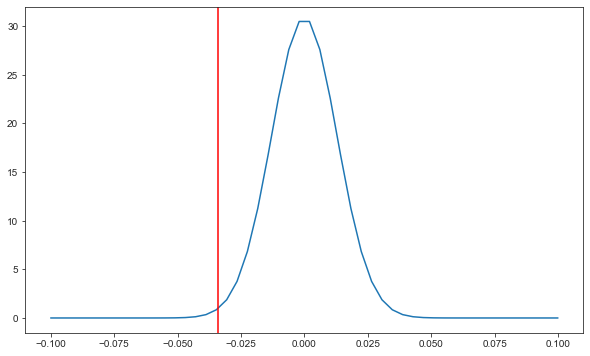

In [35]:
fig, ax = plt.subplots(figsize=(10,6))

x = np.linspace(-.1,.1)
pdf = scipy.stats.norm.pdf(x,
                           0,
                           combined_standard_error)
plt.plot(x, pdf);
ax.axvline(diff_mean, color="r");

In [36]:
t = diff_mean / combined_standard_error
t

-2.6322465605806453

In [37]:
scipy.stats.ttest_ind(df.loc[df["experiment_id"].eq(101),"review_score"],
                      df.loc[df["experiment_id"].eq(102),"review_score"],
                      equal_var=False)

Ttest_indResult(statistic=-2.6322465605806493, pvalue=0.008485564619965413)